In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from copy import deepcopy
from itertools import product

from data_loaders import Dataset, MedicalDataset, MissDataset, DataLoadersEnum, split_parkinsons_data

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [2]:
def test_data_loader(CURRENT_SUPPORTED_DATALOADERS):
        for dataset in CURRENT_SUPPORTED_DATALOADERS:
                print(f"This is the current dataset: {dataset}")
                data_preparation_function_object = CURRENT_SUPPORTED_DATALOADERS[dataset]
                data,dataset_name,target_col = data_preparation_function_object()
                # Display missing data visually
                msno.matrix(data)
                plt.title(f"Dataset {dataset} (Full Dataset)")  # Adding a title specific to the imputation method
                plt.show()  # Display the plot
                # Display missing data numerically
                missing_data = data.isnull().sum()
                print(missing_data)

        return data,dataset_name,target_col

In [3]:



def test_synthetic_missingness(data, dataset_name, target_col, miss_param_dict):
    miss_param_grid = list(product(*tuple(miss_param_dict.values())))

    for i, params in enumerate(miss_param_grid):
        print(f"\n params= {params}")
        data_copy = deepcopy(data)
        params = {
            k: p
            for k, p in zip(list(miss_param_dict.keys()), params)
        }
        dataset = MissDataset(
            data=data_copy,
            target_col=target_col,
            n_folds=5,
            **params,
        )

        # Display missing data visually
        msno.matrix(dataset.data)
        plt.title(f"Dataset {dataset_name} with missing values {params} (Pre-Imputation)")  # Adding a title specific to the imputation method
        plt.show() 

        # Display missing data numerically
        missing_data = dataset.data.isnull().sum()
        print(missing_data)
    return dataset


In [5]:


def test_imputation(missdata):
    data_with_missing_values = missdata.data
    # Parameters for the imputers
    xgb_params = {'n_jobs': 1, 'max_depth': 4, 'n_estimators': 50, 'verbosity': 0}
    rf_params = {'n_jobs': 1, 'max_depth': 4, 'n_estimators': 50, 'verbose': 0}
    knn_params = {'weights': 'distance', 'n_neighbors': 5}


    imputation_methods = {
        "BayesianRidge": IterativeImputer(estimator=BayesianRidge()),
        "XGBRegressor": IterativeImputer(estimator=XGBRegressor(**xgb_params)),
        "RandomForestRegressor": IterativeImputer(estimator=RandomForestRegressor(**rf_params)),
        "KNNImputer": KNNImputer(**knn_params)
    }
    
    imputed_datasets = {}
    
    for key, imputer in imputation_methods.items():
        try:
            print(f"Imputing data with {key}")     
            imputed_data = imputer.fit_transform(data_with_missing_values)
            imputed_data = pd.DataFrame(imputed_data, columns=data_with_missing_values.columns)  # Convert to DataFrame
            imputed_datasets[key] = imputed_data
            print(f"Imputation with {key} completed successfully.")
        except Exception as e:
            print(f"Error during imputation with {key}: {e}")
    
    # Validation step: check for any remaining NaN values
    for key, data in imputed_datasets.items():
        if data.isnull().any().any():
            print(f"NaN values found in dataset after imputation with {key}.")
        else:
            print(f"No NaN values in dataset after imputation with {key}.")
    
    return imputed_datasets


This is the current dataset: wdbc


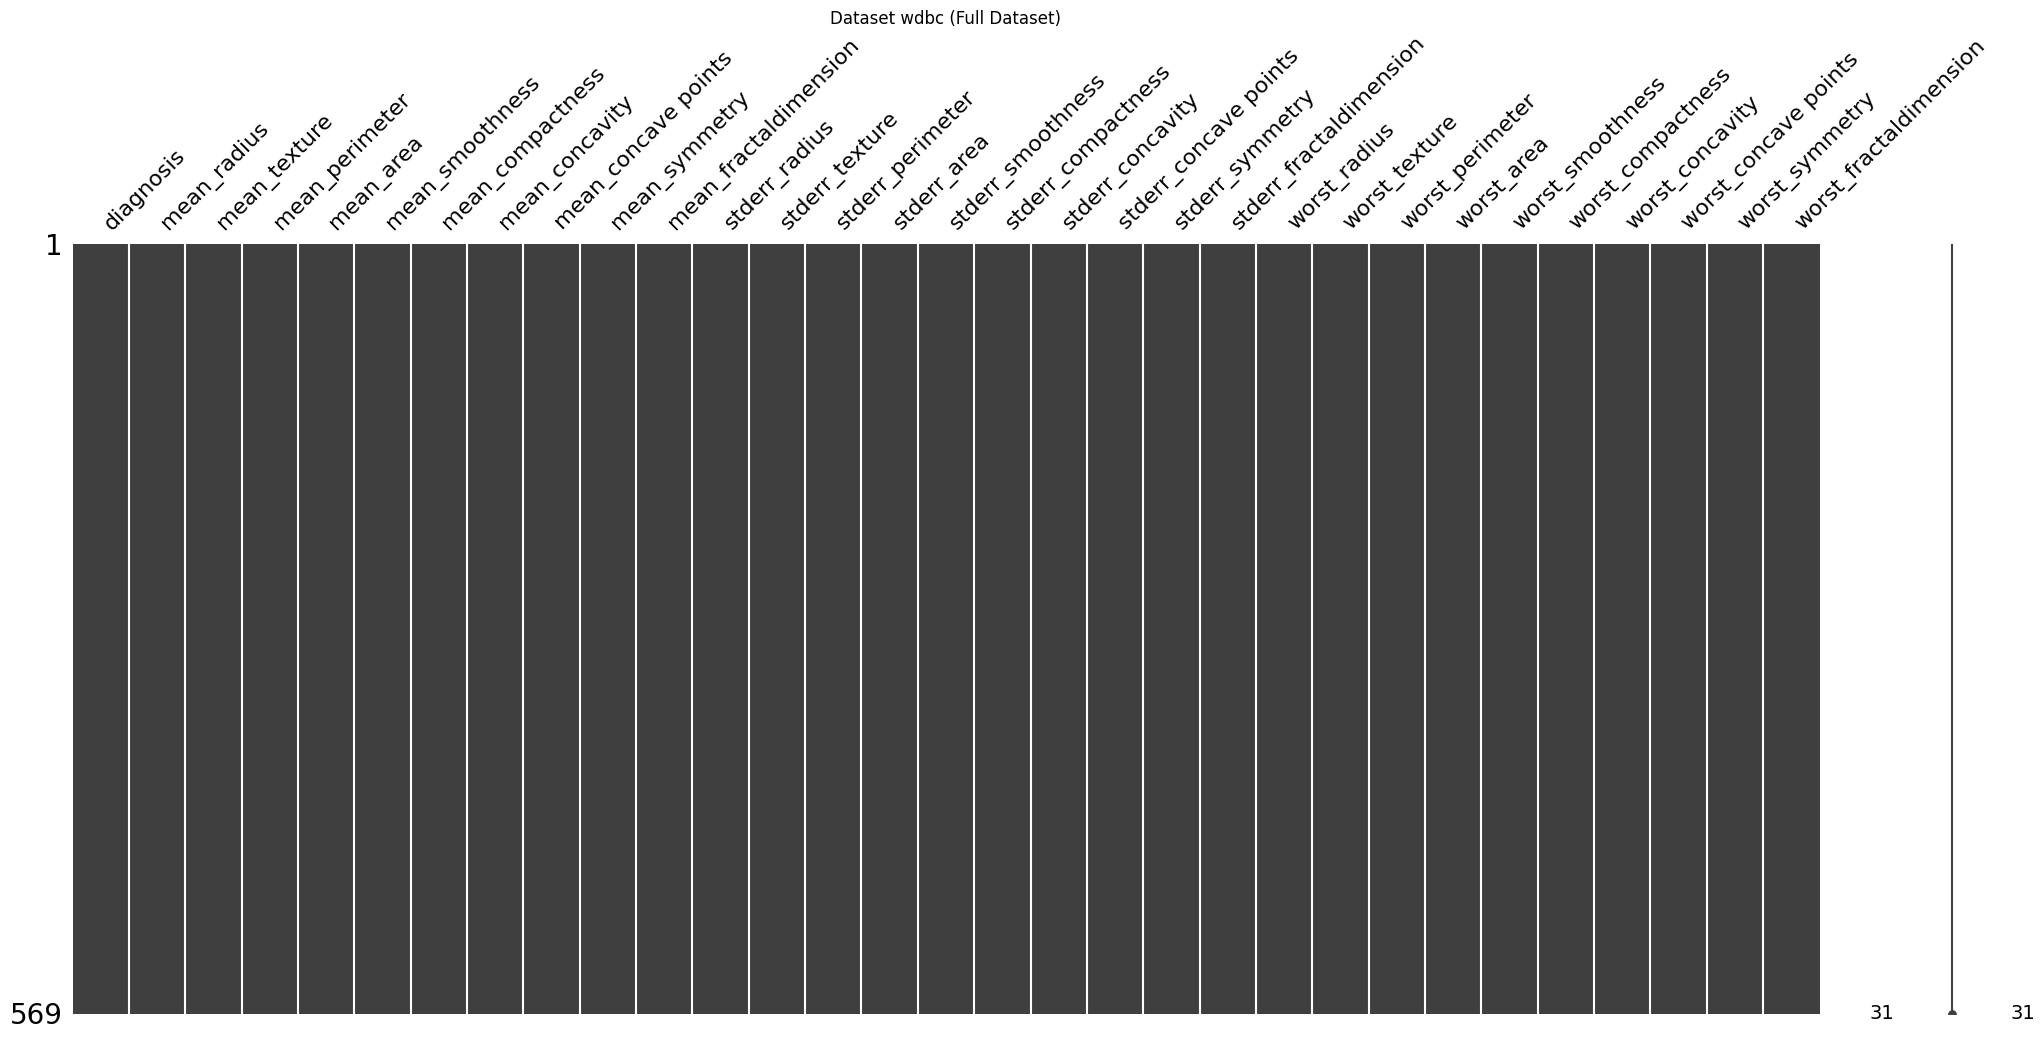

diagnosis                  0
mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave points        0
mean_symmetry              0
mean_fractaldimension      0
stderr_radius              0
stderr_texture             0
stderr_perimeter           0
stderr_area                0
stderr_smoothness          0
stderr_compactness         0
stderr_concavity           0
stderr_concave points      0
stderr_symmetry            0
stderr_fractaldimension    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave points       0
worst_symmetry             0
worst_fractaldimension     0
dtype: int64


In [6]:



CURRENT_SUPPORTED_DATALOADERS = {
    # 'eeg_eye_state': DataLoadersEnum.prepare_eeg_eye_data,
    # 'Cleveland Heart Disease': DataLoadersEnum.prepare_cleveland_heart_data,
    # 'diabetic_retinopathy': DataLoadersEnum.prepare_diabetic_retinopathy_dataset,
    ##'wpbc': DataLoadersEnum.prepare_wpbc_data,
    'wdbc': DataLoadersEnum.prepare_wdbc_data
    # 'parkinsons': DataLoadersEnum.prepare_parkinsons_data,
    # 'cervical_cancer': DataLoadersEnum.prepare_cervical_cancer_data,
    ## 'myocardial_infarction': DataLoadersEnum.prepare_myocardial_infarction_data,
    # 'student': DataLoadersEnum.prepare_student_data,
    ## 'diabetes_vcu': DataLoadersEnum.prepare_diabetes_vcu_dataset
}

data,dataset_name,target_col=test_data_loader(CURRENT_SUPPORTED_DATALOADERS)




 params= (0.6, 'MCAR', None, None, None)


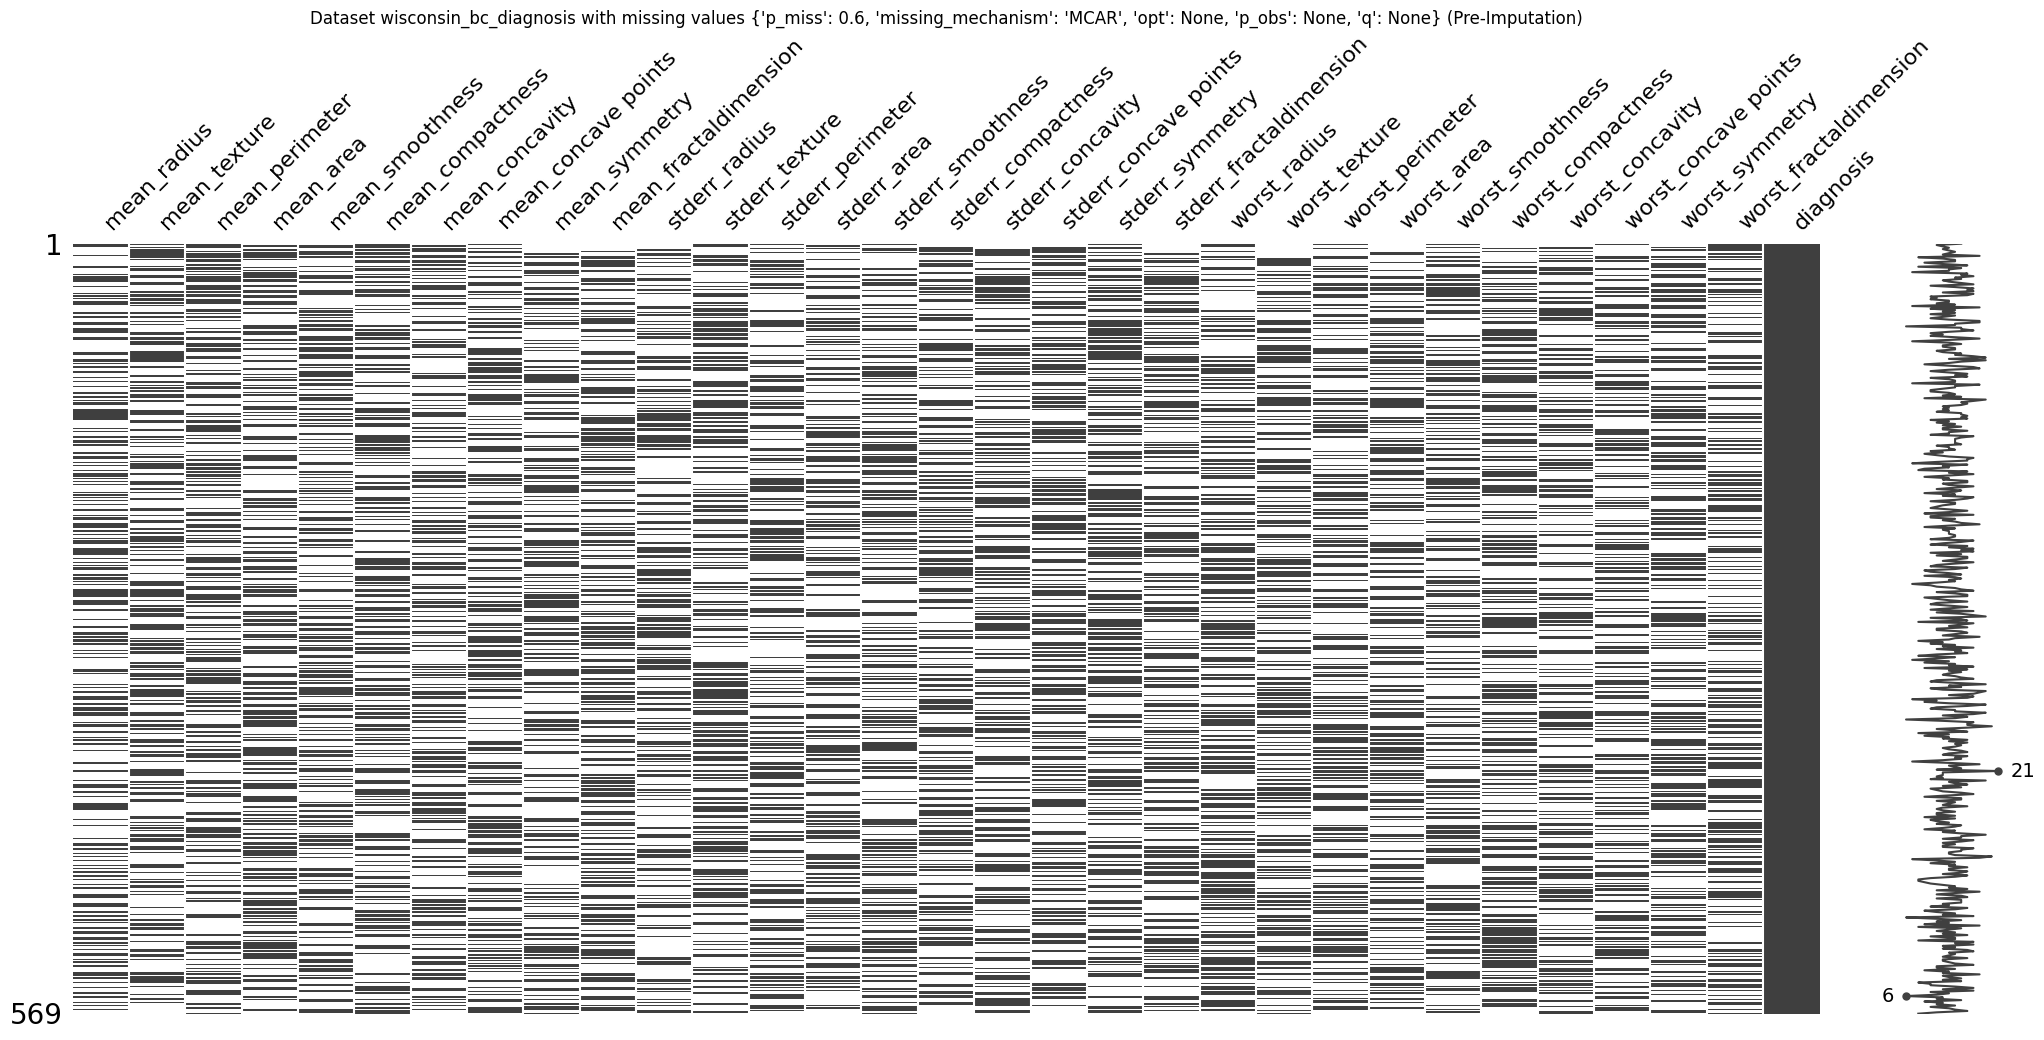

mean_radius                344
mean_texture               338
mean_perimeter             327
mean_area                  326
mean_smoothness            342
mean_compactness           340
mean_concavity             353
mean_concave points        333
mean_symmetry              351
mean_fractaldimension      326
stderr_radius              362
stderr_texture             327
stderr_perimeter           352
stderr_area                348
stderr_smoothness          341
stderr_compactness         343
stderr_concavity           338
stderr_concave points      324
stderr_symmetry            317
stderr_fractaldimension    333
worst_radius               324
worst_texture              325
worst_perimeter            340
worst_area                 339
worst_smoothness           339
worst_compactness          315
worst_concavity            346
worst_concave points       348
worst_symmetry             328
worst_fractaldimension     341
diagnosis                    0
dtype: int64


In [7]:
MCAR_PARAM_DICT = {
        # 'p_miss': [x/10 for x in range(3,9)], 
        'p_miss': [0.6],
        'missing_mechanism': ["MCAR"],
        'opt': [None],
        'p_obs': [None],
        'q': [None],
    }

MAR_PARAM_DICT = {
        # 'p_miss': [x/10 for x in range(3,9)], 
        'p_miss': [0.1],
        'missing_mechanism': ["MAR"],
        'opt': [None],
        'p_obs': [0.3],
        'q': [None],
    }

MNAR_PARAM_DICT = {
        'p_miss': [0.1],
        'missing_mechanism': ["MNAR"],
        'opt': ['logistic'],
        'p_obs': [0.3],
        'q': [None],
    }

miss_param_dict= MCAR_PARAM_DICT
miss_data=test_synthetic_missingness(data,dataset_name, target_col, miss_param_dict)


Imputing data with BayesianRidge
Imputation with BayesianRidge completed successfully.
Imputing data with XGBRegressor


/Users/dylandominguez/StudioProjects/M-DEW/.venv/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Imputation with XGBRegressor completed successfully.
Imputing data with RandomForestRegressor


/Users/dylandominguez/StudioProjects/M-DEW/.venv/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Imputation with RandomForestRegressor completed successfully.
Imputing data with KNNImputer
Imputation with KNNImputer completed successfully.
No NaN values in dataset after imputation with BayesianRidge.
No NaN values in dataset after imputation with XGBRegressor.
No NaN values in dataset after imputation with RandomForestRegressor.
No NaN values in dataset after imputation with KNNImputer.
=======================================Visual and numerical data analysis for BayesianRidge:=========================================================


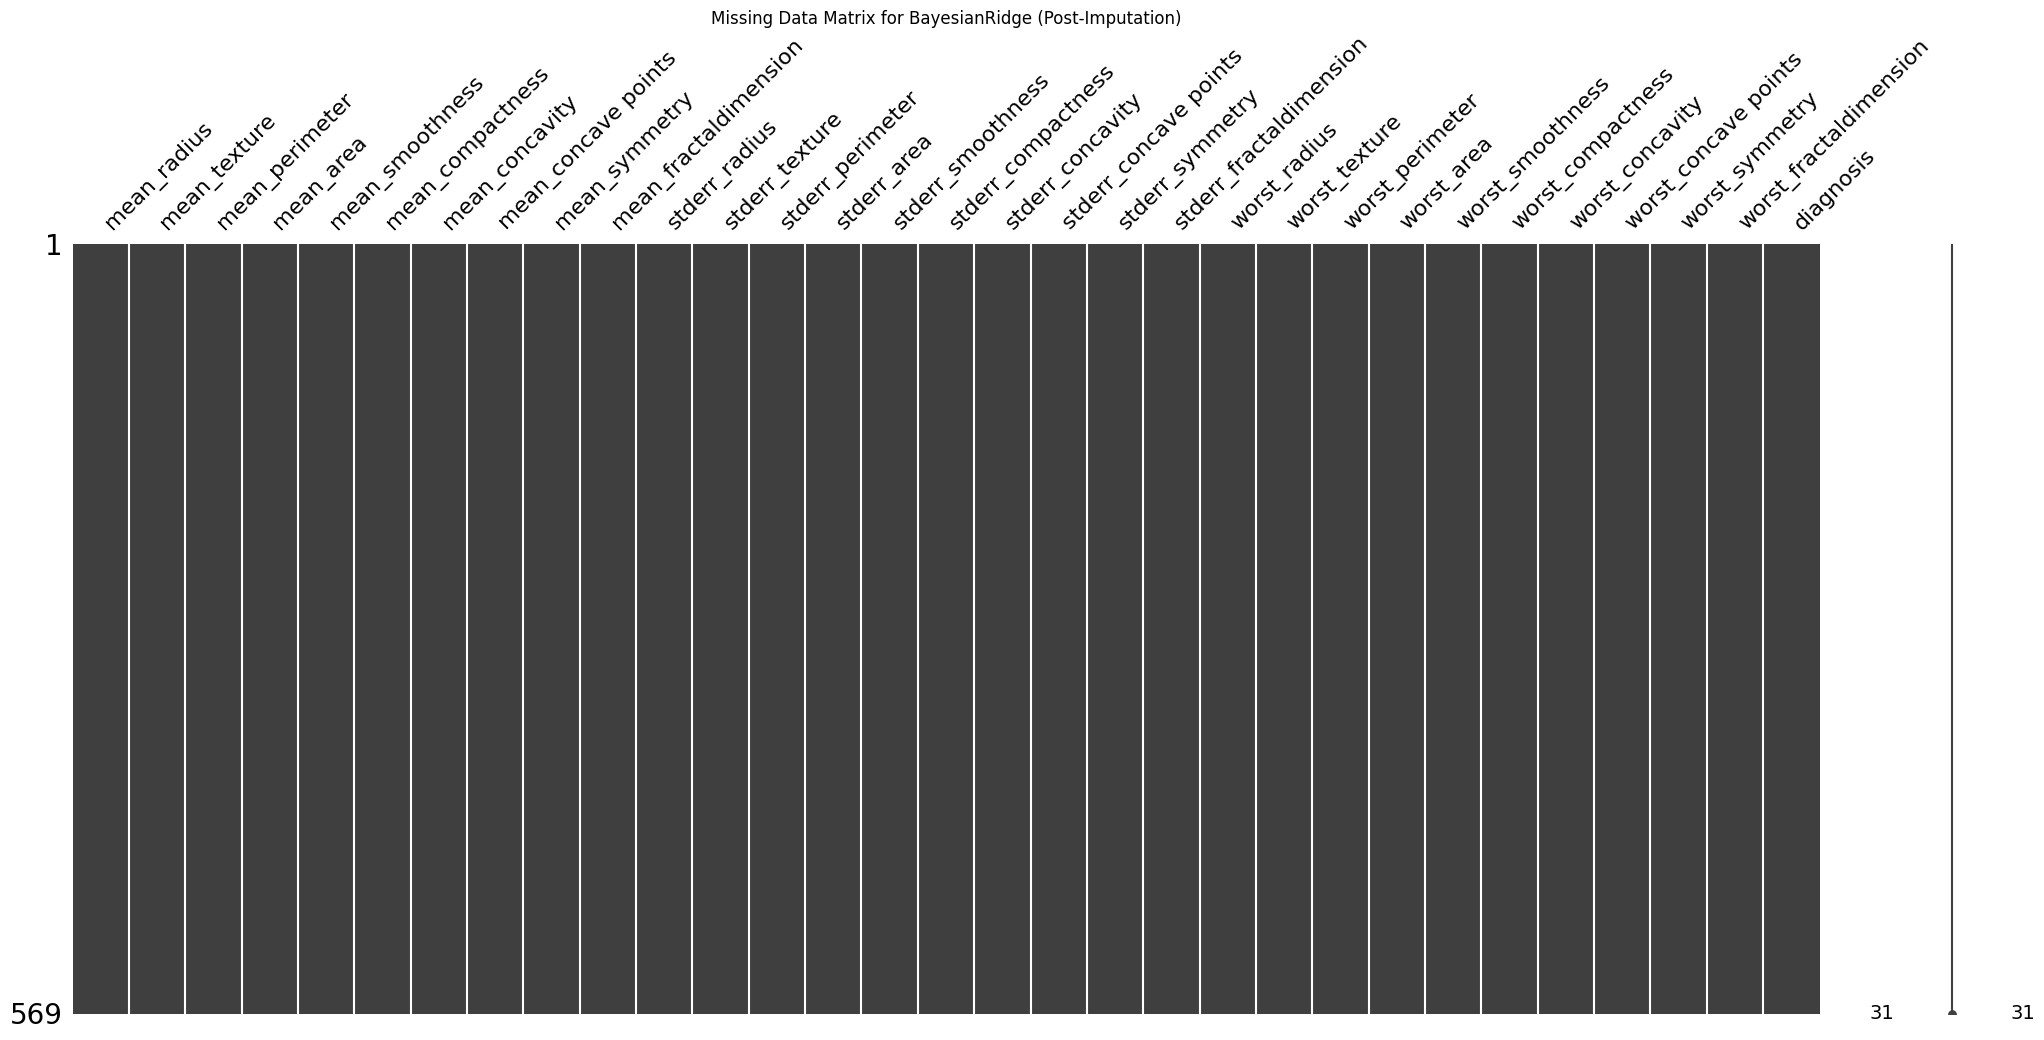

mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave points        0
mean_symmetry              0
mean_fractaldimension      0
stderr_radius              0
stderr_texture             0
stderr_perimeter           0
stderr_area                0
stderr_smoothness          0
stderr_compactness         0
stderr_concavity           0
stderr_concave points      0
stderr_symmetry            0
stderr_fractaldimension    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave points       0
worst_symmetry             0
worst_fractaldimension     0
diagnosis                  0
dtype: int64
=======================================Visual and numerical data analysis for XGBRegress

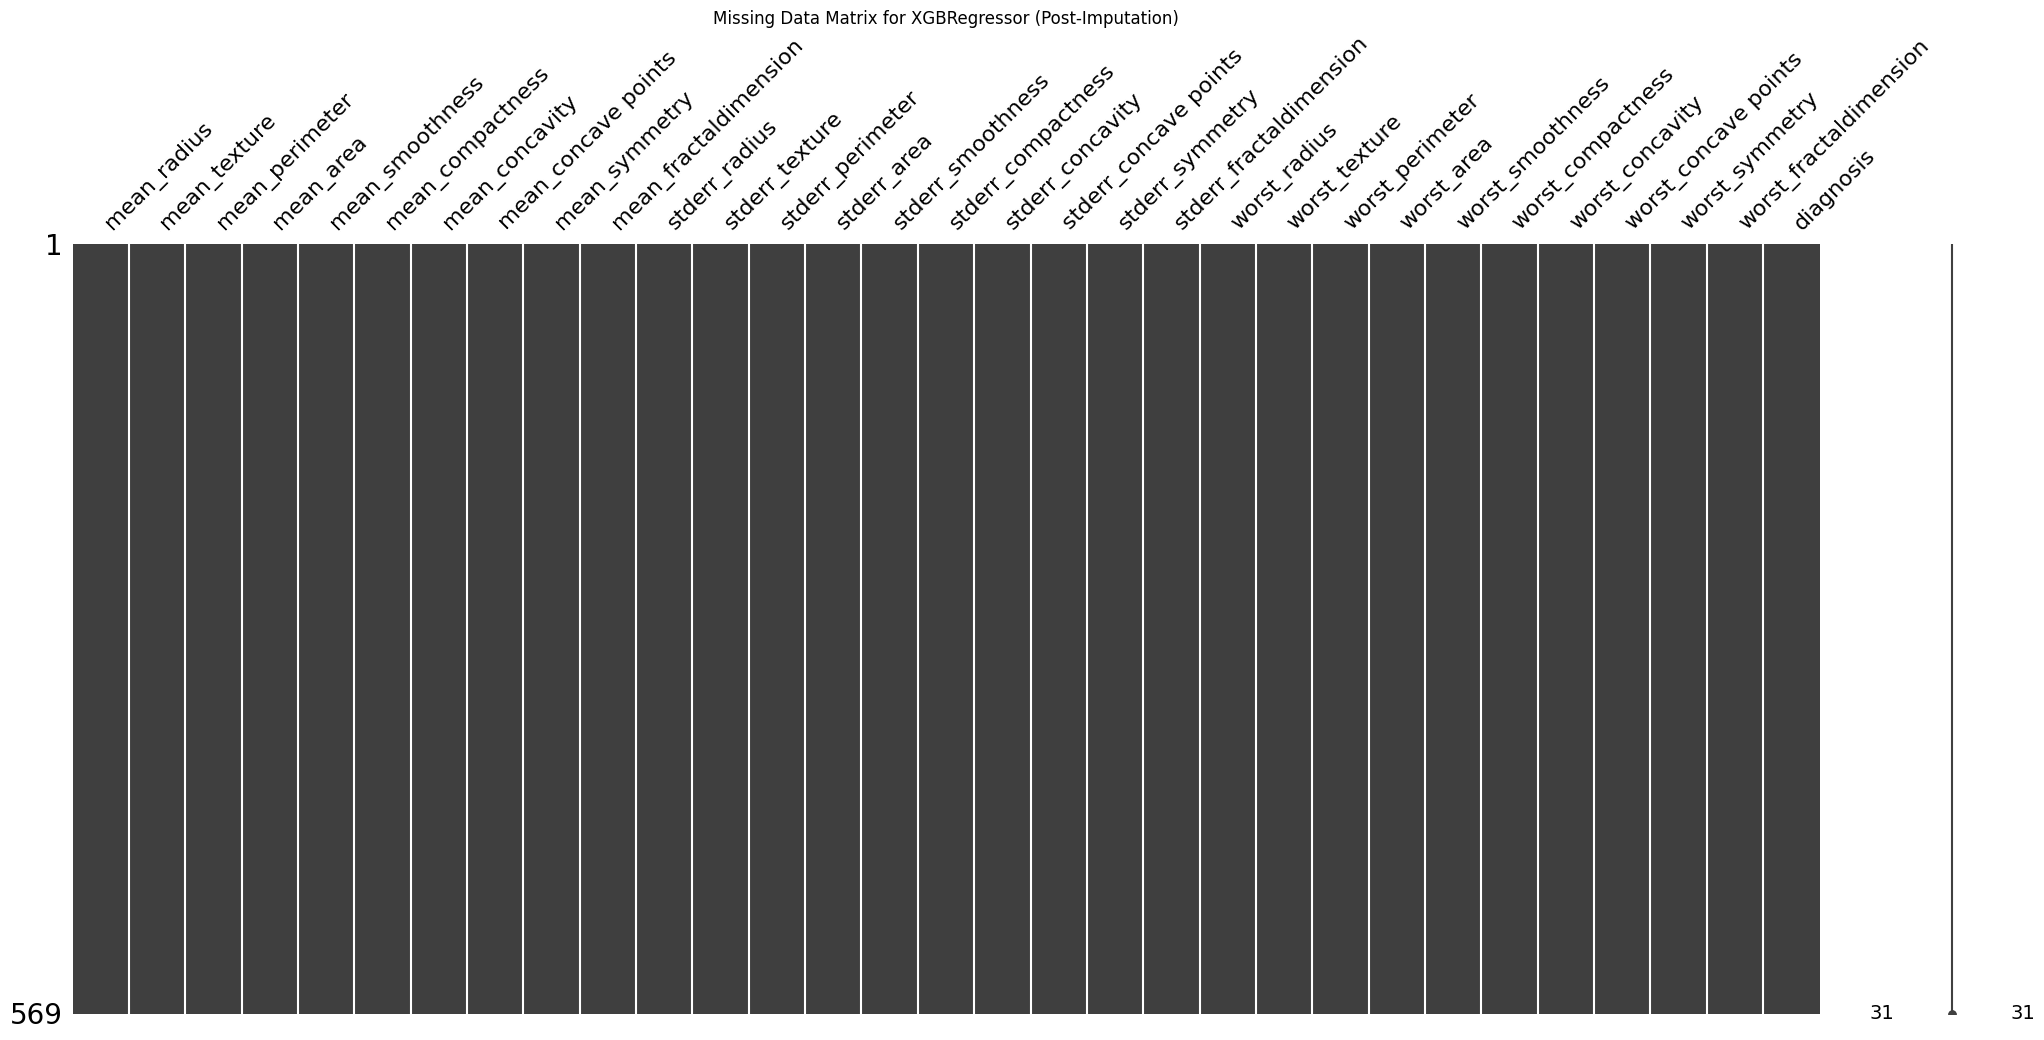

mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave points        0
mean_symmetry              0
mean_fractaldimension      0
stderr_radius              0
stderr_texture             0
stderr_perimeter           0
stderr_area                0
stderr_smoothness          0
stderr_compactness         0
stderr_concavity           0
stderr_concave points      0
stderr_symmetry            0
stderr_fractaldimension    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave points       0
worst_symmetry             0
worst_fractaldimension     0
diagnosis                  0
dtype: int64
=======================================Visual and numerical data analysis for RandomFore

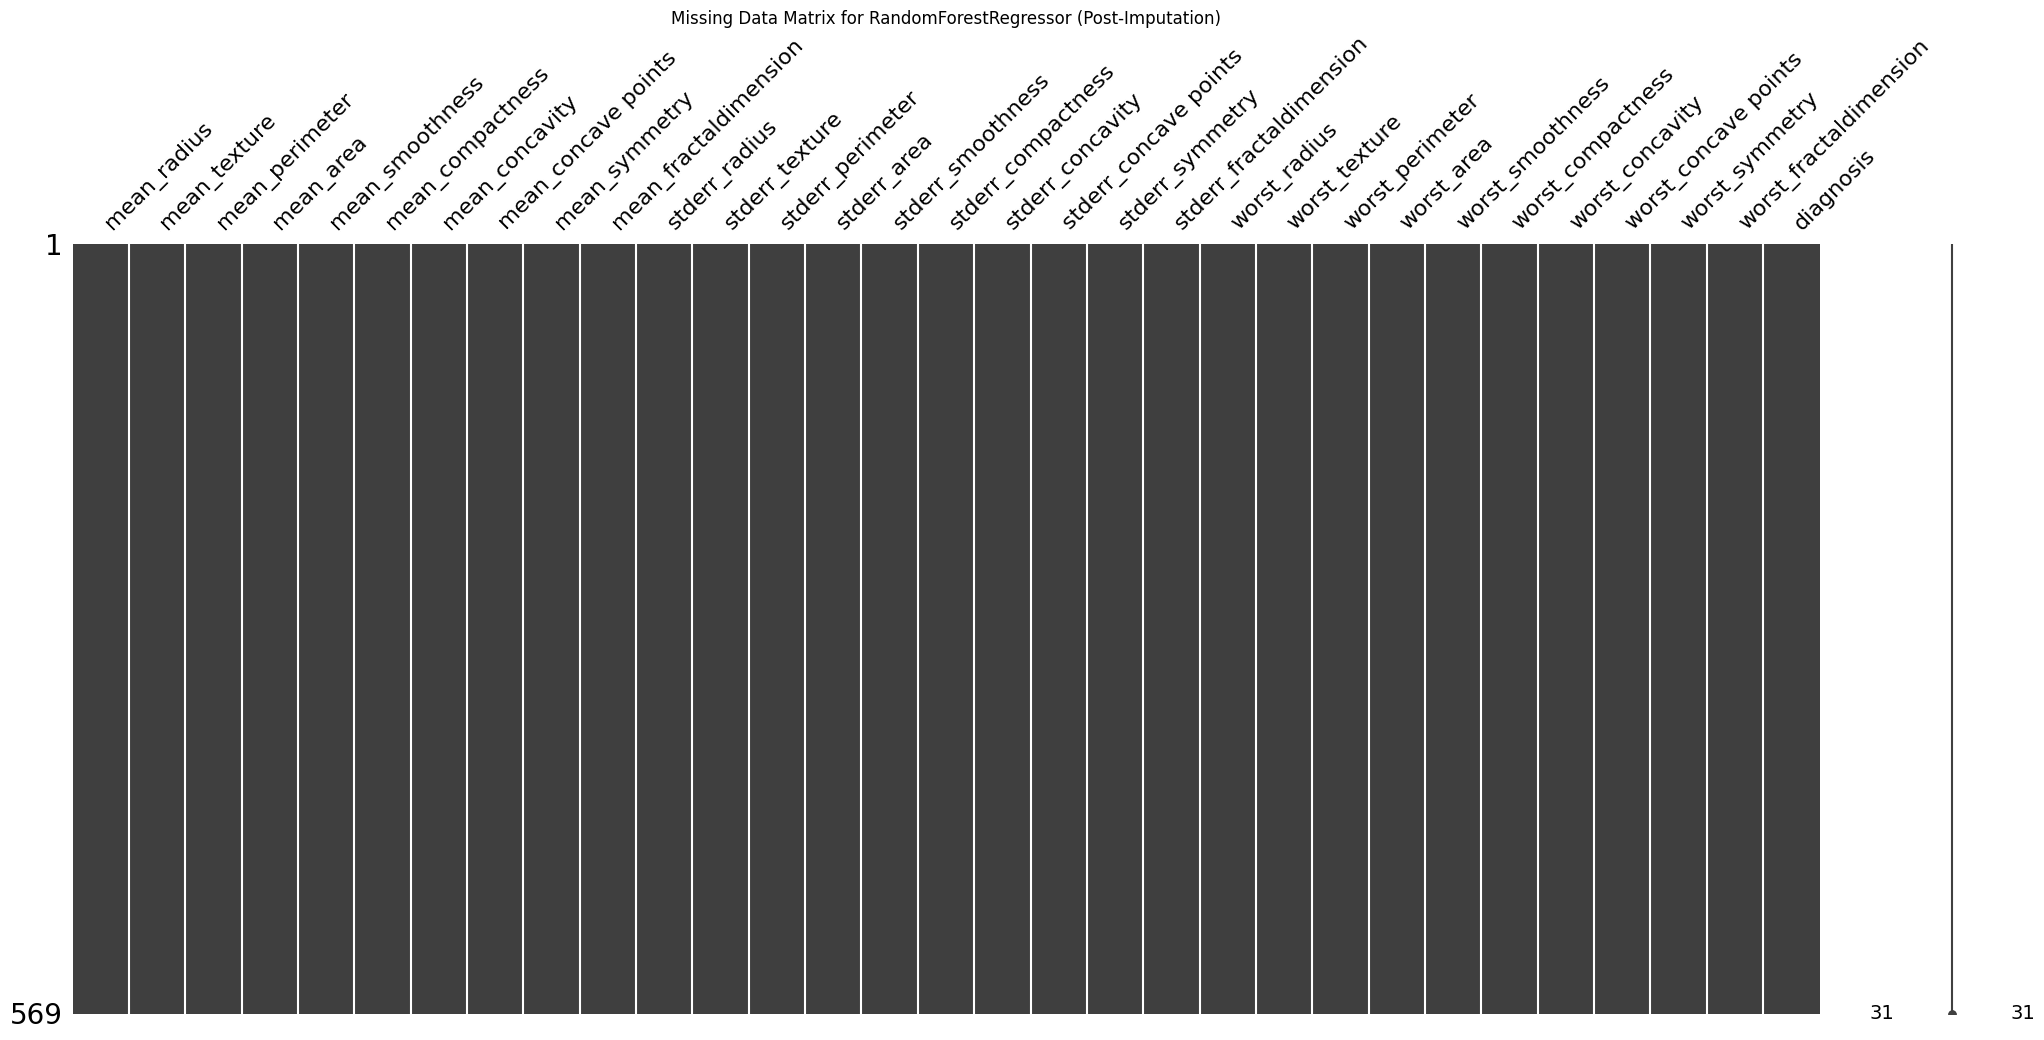

mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave points        0
mean_symmetry              0
mean_fractaldimension      0
stderr_radius              0
stderr_texture             0
stderr_perimeter           0
stderr_area                0
stderr_smoothness          0
stderr_compactness         0
stderr_concavity           0
stderr_concave points      0
stderr_symmetry            0
stderr_fractaldimension    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave points       0
worst_symmetry             0
worst_fractaldimension     0
diagnosis                  0
dtype: int64
=======================================Visual and numerical data analysis for KNNImputer

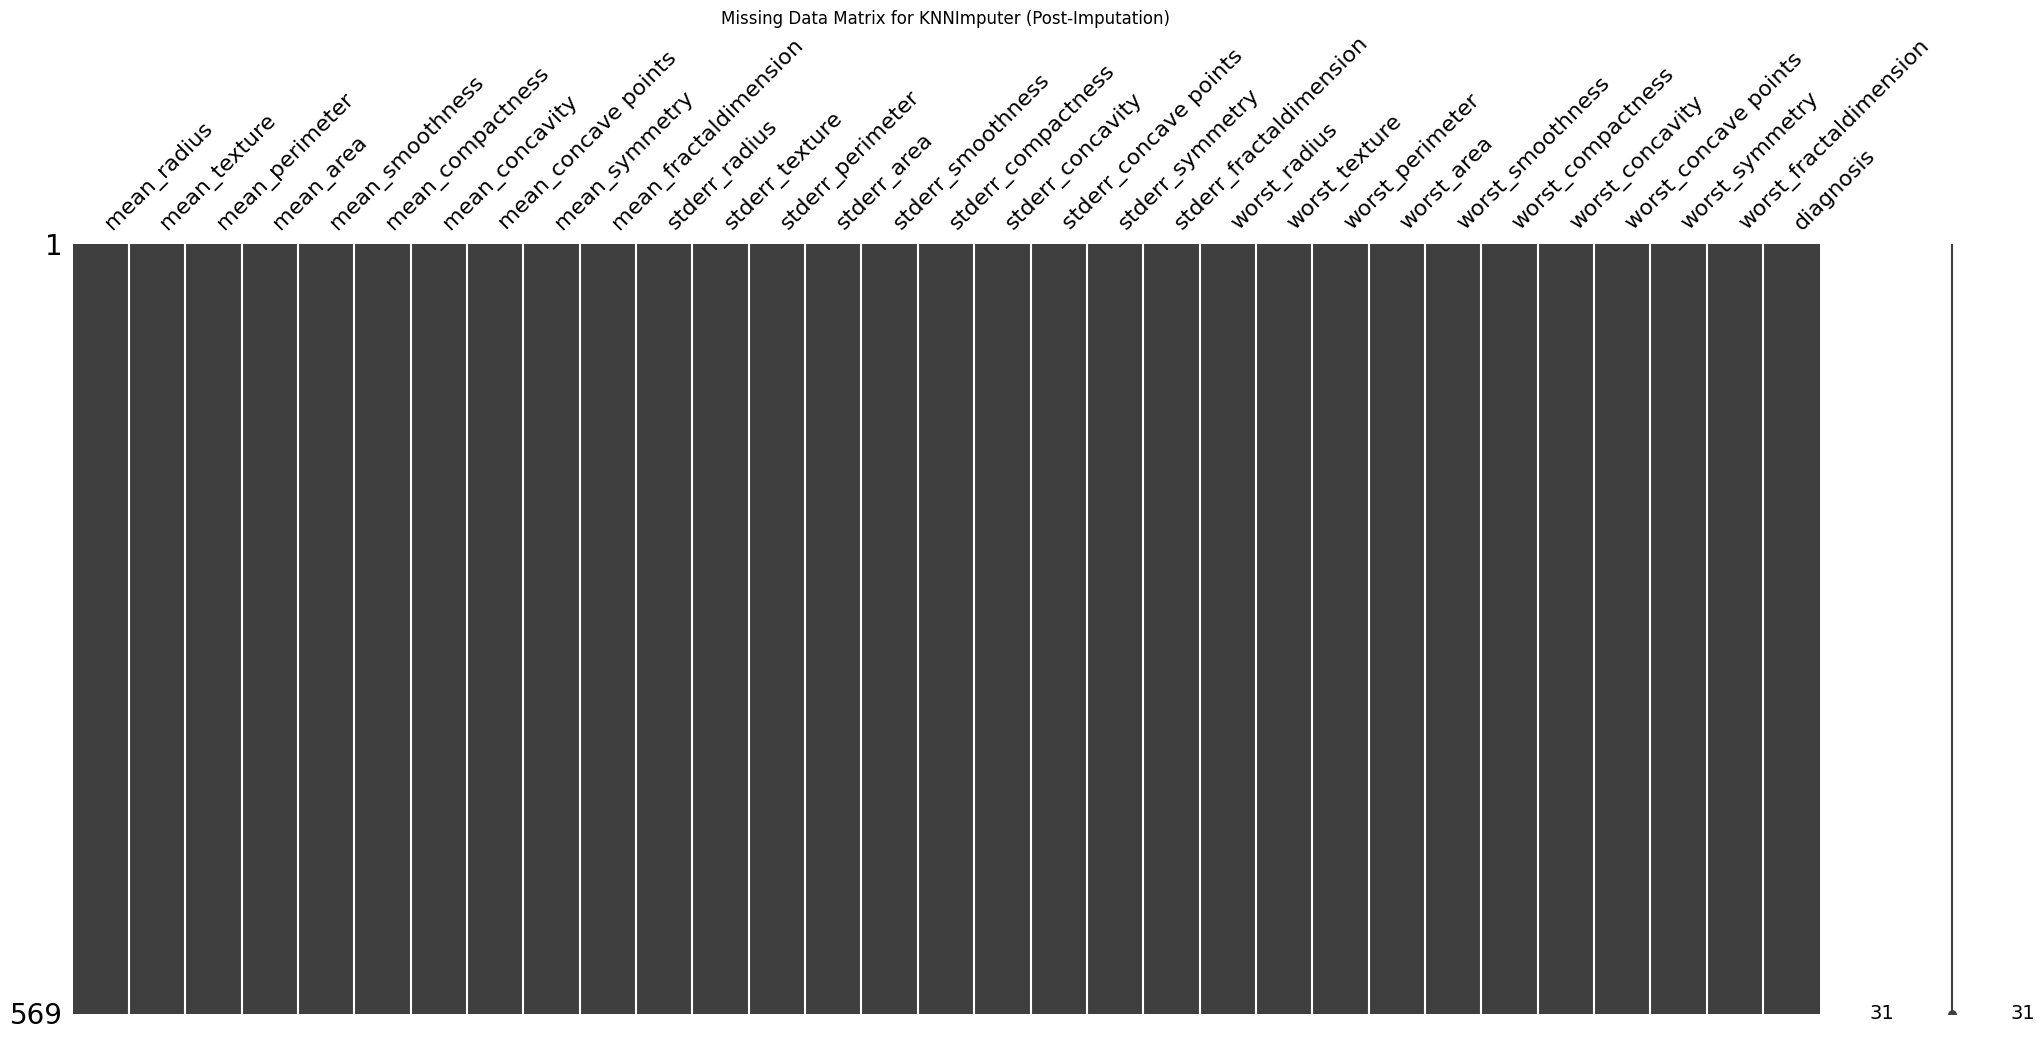

mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave points        0
mean_symmetry              0
mean_fractaldimension      0
stderr_radius              0
stderr_texture             0
stderr_perimeter           0
stderr_area                0
stderr_smoothness          0
stderr_compactness         0
stderr_concavity           0
stderr_concave points      0
stderr_symmetry            0
stderr_fractaldimension    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave points       0
worst_symmetry             0
worst_fractaldimension     0
diagnosis                  0
dtype: int64


In [8]:
imputed_datasets=test_imputation(miss_data)


for key, imputed_data in imputed_datasets.items():
    print(f"=======================================Visual and numerical data analysis for {key}:=========================================================")
    
    # Display missing data visually using missingno
    msno.matrix(imputed_data)
    plt.title(f"Missing Data Matrix for {key} (Post-Imputation)")  # Adding a title specific to the imputation method
    plt.show()  # Display the plot

    # Display missing data numerically
    missing_data = imputed_data.isnull().sum()
    print(missing_data)

